In [66]:
import pandas as pd
import geopandas as gpd
import numpy as np
import shapely
import getpass
import pymysql
import folium
from folium import plugins
from IPython.display import display

p = getpass.getpass()
connection = pymysql.connect(host = 'localhost', port = 3306, user = 'root', passwd = p)
connection.autocommit(True)
cursor = connection.cursor()

In [28]:
# Transforma texto em polígono, se não for nulo
def geometrify(wkt):
    if wkt is None:
        return np.nan
    else:
        return shapely.wkt.loads(wkt)

# Recupera o DataFrame anterior dos municípios
cursor.execute('use geo_analysis;')
query = "SELECT id, UF, name, ST_AsText(geometry) AS geometry, population, idhm, pib FROM counties;"
counties = pd.read_sql(query, con = connection)

counties['geometry'] = counties['geometry'].map(geometrify)
counties = gpd.GeoDataFrame(counties)
counties.head()

,id,UF,name,geometry,population,idhm,pib
0,1100015,RO,Alta Floresta D'Oeste,"POLYGON ((-62.18209 -11.86686, -62.16230 -11.8...",23167,0.641,16461.11
1,1100023,RO,Ariquemes,"POLYGON ((-62.53595 -9.73182, -62.50782 -9.754...",106168,0.702,19401.43
2,1100031,RO,Cabixi,"POLYGON ((-60.39940 -13.45584, -60.40195 -13.4...",5438,0.650,18346.17
3,1100049,RO,Cacoal,"POLYGON ((-61.00051 -11.39796, -61.01794 -11.4...",84813,0.718,20725.23
4,1100056,RO,Cerejeiras,"POLYGON ((-61.50047 -13.00392, -61.47901 -13.0...",16444,0.692,22179.17


In [22]:
ubs = pd.read_sql("SELECT cnes, UF, name, ST_AsText(geometry) AS geometry FROM ubs;", con = connection)

ubs['geometry'] = ubs['geometry'].map(geometrify)
ubs = gpd.GeoDataFrame(ubs)
# Quantidade de Unidades Básicas de Saúde por Unidade Federativa
ubs_uf = ubs[['cnes', 'UF']].groupby('UF').agg('count').rename(columns = {'cnes': 'count'}).reset_index()
ubs.head()

,cnes,UF,name,geometry
0,108,PE,USF ALTO DOS INDIOS,POINT (-35.03210 -8.28389)
1,116,PE,USF CHARNECA II,POINT (-35.02819 -8.28353)
2,124,PE,USF SAO FRANCISCO I,POINT (-35.03500 -8.28700)
3,132,PE,USF ROSARIO,POINT (-35.03210 -8.28389)
4,140,PE,USF JUSSARAL,POINT (-35.03500 -8.28700)


ben_bas: Benefício Básico - R$ 89,00 \
ben_var: Benefício Variável - R$ 41,00 \
ben_bvj: Benefício Variável Jovem - R$ 48 \
ben_bvn: Benefício Variável Nutriz (criança de até 6 meses) \
ben_bvg: Benefício Variável à Gestante \
ben_bsp: Benefício para a Superação da Extrema Pobreza

In [23]:
cursor.execute('use geo_analysis;')
bolsa = pd.read_sql("SELECT * FROM bolsa_familia;", con = connection)

# Define as funções usadas nas agregações
bolsa_ano = bolsa.drop(columns = ['id', 'y_m'])
functions = {x: 'mean' for x in bolsa_ano}
functions.update({'UF': 'first'})
functions.pop('ibge')

# Agrupa os dados em uma média por ano e por estado, mantendo o original
bolsa_ano = bolsa_ano.groupby('ibge').agg(functions)
bolsa_estado = bolsa_ano.groupby('UF').agg('mean')
bolsa_estado.head()

,qtd_ben_bas,qtd_ben_var,qtd_ben_bvj,qtd_ben_bvn,qtd_ben_bvg,qtd_ben_bsp
UF,,,,,,
AC,3877.943182,7202.352273,1015.818182,74.750000,174.367424,2749.840909
AL,3805.836601,4870.082516,696.629902,53.713235,136.162582,1872.531863
AM,6079.514785,11245.592742,1555.709677,91.701613,271.803763,3217.876344
AP,4458.437500,8034.916667,1123.625000,69.623958,171.572917,2593.250000
BA,4208.326139,4724.484213,722.635092,50.896483,116.331934,2146.903677


In [29]:
cursor.close()
connection.close()

In [13]:
states = counties.copy()
# Necessário para a conversão, porém perde parte da área
states['geometry'] = states.buffer(0)
states = states[['UF', 'geometry']].dissolve(by = 'UF', as_index = False)
states = states.merge(ubs_uf, on = 'UF')
states = states.merge(bolsa_estado, on = 'UF')
states.head()

,UF,geometry,count,qtd_ben_bas,qtd_ben_var,qtd_ben_bvj,qtd_ben_bvn,qtd_ben_bvg,qtd_ben_bsp
0,AC,"POLYGON ((-69.42758 -10.93700, -69.44967 -10.9...",246,3877.943182,7202.352273,1015.818182,74.750000,174.367424,2749.840909
1,AL,"POLYGON ((-37.19495 -9.89763, -37.22625 -9.899...",904,3805.836601,4870.082516,696.629902,53.713235,136.162582,1872.531863
2,AM,"POLYGON ((-68.21979 -9.24215, -68.63703 -9.053...",592,6079.514785,11245.592742,1555.709677,91.701613,271.803763,3217.876344
3,AP,"POLYGON ((-51.26526 -0.19511, -51.28914 -0.227...",126,4458.437500,8034.916667,1123.625000,69.623958,171.572917,2593.250000
4,BA,"MULTIPOLYGON (((-42.33081 -15.07951, -42.33685...",3908,4208.326139,4724.484213,722.635092,50.896483,116.331934,2146.903677


<AxesSubplot:>

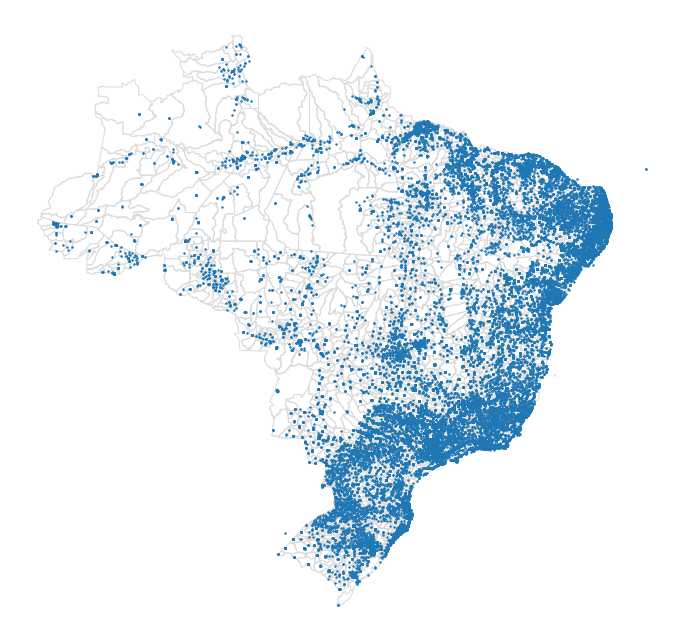

In [80]:
# Mapa inicial - pontos representam Unidades Básicas de Saúde (UNBs)

base = counties.plot(figsize = (12,12), color = 'none', edgecolor = 'gainsboro', zorder = 1)
base.set_axis_off()
ubs.dropna(subset=['geometry']).plot(ax = base, legend = False, zorder = 2, markersize = 2)

<AxesSubplot:>

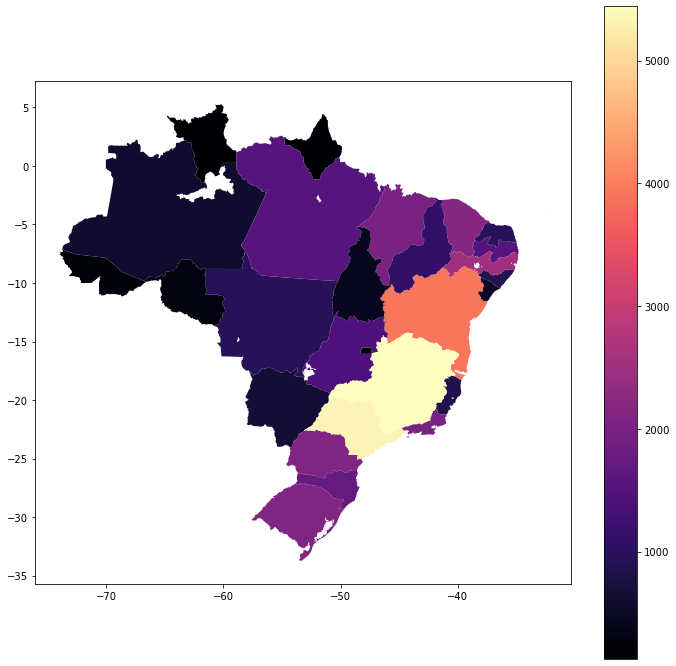

In [64]:
# Quantidade de UNBs por estado
states.plot(column = 'count',
              figsize = (12,12),
              cmap = 'magma',
              vmax = states['count'].quantile(0.98),
              legend = True)

In [ ]:
# Requer geopandas >= 1.10

def explore(column, color='Blues', dark=True):
    theme = ['OpenStreetMap', 'CartoDB dark_matter']
    m = folium.Map(location=[-15, -53], zoom_start=4, tiles=theme(int(dark)))
    counties.explore(
        m = m,
        column = column,
        categorical = False,
        vmax = counties[column].quantile(0.98),
        cmap = color, 
        legend = True,
        tooltip = ['name', column],
        tooltip_kwds = dict(labels=False),
        name = 'Municípios'
    )
    folium.TileLayer(theme(int(not dark)), control = True).add_to(m)
    folium.LayerControl().add_to(m)
    display(m)

explore('population', dark=False)

"""
marker_type: folium.Circle, folium.CircleMarker, folium.Marker
marker_kwds: {radius = 2, fill = True, icon = folium.map.Icon, draggable = False}
style_kwds: {stroke, color, weight, fill, fillColor, fillOpacity}


Schemes: 'BoxPlot', 'EqualInterval', 'FisherJenks', 'FisherJenksSampled', 'HeadTailBreaks'
         'JenksCaspall', 'JenksCaspallForced', 'JenksCaspallSampled', 'MaxP', 'MaximumBreaks'
         'NaturalBreaks', 'Quantiles', 'Percentiles', 'StdMean', 'UserDefined'

Layers : "OpenStreetMap", "Stamen Terrain", “Stamen Toner", “Stamen Watercolor" "CartoDB positron", “CartoDB dark_matter"
"""

In [ ]:
explore('idhm', 'winter', False)

In [ ]:
explore('pib', 'autumn_r', True)

ben_bas: Benefício Básico - R$ 89,00 \
ben_var: Benefício Variável - R$ 41,00 \
ben_bvj: Benefício Variável Jovem - R$ 48 \
ben_bvn: Benefício Variável Nutriz (criança de até 6 meses) \
ben_bvg: Benefício Variável à Gestante \
ben_bsp: Benefício para a Superação da Extrema Pobreza

No mapa abaixo, selecione a camada desejada marcada no ícone de LayerControl.

In [ ]:
m = folium.Map(location=[-15, -53], zoom_start=4, tiles=None, control_scale=True)

for column in states.columns[3:]:
    if column == 'qtd_ben_bas':
        show = True
    else:
        show = False
    x = folium.FeatureGroup(name=column, show=show, overlay=False)
    states.explore(
        m = x,
        cmap = 'viridis',
        # Devido à diferença de valores do DF, define-se o valor máximo como o segundo maior
        vmax = states[column].sort_values().iloc[-2],
        legend = True,
        column = column,
        categorical = False,
        tooltip = ['UF', column],
        tooltip_kwds = dict(labels = False),
        k = 20, # Number of classes (5)
        name = column
    )
    folium.TileLayer('OpenStreetMap', control = True).add_to(x)
    x.add_to(m)

folium.LayerControl().add_to(m)
m

In [ ]:
# HeatMap da densidade de Unidades Básicas de Saúde
# Mais expressivo em níveis maiores de zoom

m = folium.Map(location = [-15, -53], tiles='Cartodb dark_matter', zoom_start = 4)
heat_data = [[point.xy[1][0], point.xy[0][0]] for point in ubs.dropna(subset = ['geometry']).geometry]

plugins.HeatMap(heat_data).add_to(m)
m

<br/>
<br/>

# Análises 2  
<br/>

1º tentativa: Mapa de Pontos - Unidades Básicas de Saúde no Brasil (pontuar todas as unidades de saúde no Brasil. Obs.: Tentar colocar seleção de legenda. ex = (mostrar somente unidades da região sul)).  
<br/>
Lembrar: 
* brazil = Cities data
* states = States data

In [ ]:
m = folium.Map(location=[-15, -53], zoom_start=4, tiles='OpenStreetMap')

states.explore(
     m = m,
     column= 'count',
     categorical = True,
     scheme="naturalbreaks",
     legend=True,
     k=10, 
     legend_kwds=dict(colorbar=False), 
     name="Estados" 
)


folium.TileLayer('Stamen Toner', control=True).add_to(m)  # use folium to add alternative tiles
folium.LayerControl().add_to(m)  # use folium to add layer control


m  # show map

In [38]:
ubs_loc = ubs[['geometry']]
ubs_coord = [[point.xy[1][0], point.xy[0][0]] for point in ubs_loc.geometry]

 
ubs_loc_list = ubs_loc.values.tolist()
ubs_loc_list_size = len(ubs_coord)
ubs_loc_list_size




39650

In [19]:
citi_loc = counties[['geometry']]
citi_loc_list = citi_loc.values.tolist()
citi_loc_list_size = len(citi_loc_list)
citi_loc_list_size

5564

In [49]:
from shapely.geometry import Point, Polygon
#for n in range(0, citi_loc_list_size):
#print(citi_loc_list[1000])
#citi_loc_list[1000].contains(ubs_loc_list[1000])
ubs_loc = ubs[['geometry']]
x = ubs_loc.loc[0]
y = citi_loc.loc[0]
y.contains(x)
#why?

NameError: name 'citi_loc' is not defined

In [53]:


count_ubs_citi = [0]
for n in range(0, citi_loc_list_size):
    count_ubs_citi[n] = 0
    for x in range(0, ubs_loc_list_size):
        w = citi_loc.loc[n].contains(ubs_loc.loc[x])
        if w == True:
            count_ubs_citi[n] = count_ubs_citi[n] + 1
            

count_ubs_citi

AttributeError: 'Series' object has no attribute 'contains'

In [16]:
for point in range(0, ubs_loc_list_size):
    folium.Marker(ubs_coord[point]).add_to(m)
    
#m

#Este mapa com 39 mil pontos marcando as unidades básicas de saúde, explode o notebook. Não tente com menos de 16gb ram (potássio, potássio, potássio)

In [17]:
ubs_coord = [[point.xy[1][0], point.xy[0][0]] for point in ubs_loc.geometry]
ubs_coord

[[-8.28389, -35.0321],
 [-8.28353, -35.02819],
 [-8.287, -35.035],
 [-8.28389, -35.0321],
 [-8.287, -35.035],
 [-8.287, -35.035],
 [-8.287, -35.035],
 [-8.287, -35.035],
 [-8.2243, -34.96841],
 [-8.2313, -34.98027],
 [-8.287, -35.035],
 [-8.287, -35.035],
 [-8.287, -35.035],
 [-8.21801, -35.22946],
 [-8.287, -35.035],
 [-8.287, -35.035],
 [-8.287, -35.035],
 [-8.28389, -35.0321],
 [-8.294, -35.04758],
 [-8.28389, -35.0321],
 [-8.05296, -34.92863],
 [-8.08624, -34.89063],
 [-8.054, -34.881],
 [-8.054, -34.881],
 [-8.00405, -34.89683],
 [-8.14022, -34.9108],
 [-8.08318, -34.93917],
 [-8.054, -34.881],
 [-8.02078, -34.90473],
 [-8.10258, -34.91197],
 [-8.21351, -35.22553],
 [-8.054, -34.881],
 [-8.11963, -34.94724],
 [-8.11638, -34.91198],
 [-8.054, -34.881],
 [-8.054, -34.881],
 [-8.13303, -34.9364],
 [-17.55324, -39.71757],
 [-8.054, -34.881],
 [-8.00051, -34.93226],
 [-8.054, -34.881],
 [-8.00111, -34.92354],
 [-8.054, -34.881],
 [-8.054, -34.881],
 [-8.08828, -34.93816],
 [-8.054, -34